In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt

from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

AlreadyExistsError: Another metric with the same name already exists.

In [2]:
# if CUDA is available, use GPU and set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: GeForce RTX 2080 Ti


device(type='cuda')

In [3]:
max_length_smiles = 29
G_input = 100

class Token(nn.Embedding):
    def __init__(self, vocab_size, embed_size=200, padding_idx=0):
        super().__init__(vocab_size, embed_size, padding_idx)
        
token = Token(30)

def convertToASCII(item):
    ascii = []
    for char in item:
        ascii.append(ord(char))
        
    return ascii

def convertASCIIToString(items):
    result = ""
    for item in items:
        result = result + chr(item)
    return result

In [4]:
# dataset class

class qm9Dataset(Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None, skiprows=1, dtype='unicode')
        #print(self.data_df)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        smiles = (self.data_df.iloc[index,0] + " " * max_length_smiles)[0:max_length_smiles]
        #print("smiles", smiles)
        smiles = torch.cuda.FloatTensor(convertToASCII(smiles)) / 128.0   #ascii max value
        #smiles = smiles.reshape(-1)
        #smiles = smiles.unsqueeze(-1)
        #print("smiles.shape", smiles.shape)

        labels = []
        labels.append(float(self.data_df.iloc[index,1]))
        labels.append(float(self.data_df.iloc[index,2]))
        labels.append(float(self.data_df.iloc[index,3]))
        labels.append(float(self.data_df.iloc[index,4]))
        labels.append(float(self.data_df.iloc[index,5]))
        labels.append(float(self.data_df.iloc[index,6]))
        labels.append(float(self.data_df.iloc[index,7]))
        labels.append(float(self.data_df.iloc[index,8]))
        labels.append(float(self.data_df.iloc[index,9]))
        labels.append(float(self.data_df.iloc[index,10]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,11]))
        labels.append(float(self.data_df.iloc[index,12]))
        
        labels = torch.cuda.FloatTensor(labels)
        
        target = torch.zeros((len(self.data_df))).to(device)
        target[index] = 1.0
        
        return smiles,labels,target
    
    pass

In [5]:
qm9dataset = qm9Dataset('dataset/qm9.csv')

In [6]:
qm9dataset[2]

(tensor([0.6172, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500,
         0.2500, 0.2500]),
 tensor([ 1.8511e+00,  6.3100e+00, -2.9280e-01,  6.8700e-02,  3.6150e-01,
          1.9000e+01,  2.1375e-02,  6.0020e+00, -7.6405e+01, -7.6402e+01,
         -7.6401e+01, -7.6401e+01, -7.6422e+01]),
 tensor([0., 0., 1.,  ..., 0., 0., 0.]))

In [7]:
from torch.utils.data import DataLoader
data_loader = torch.utils.data.DataLoader(qm9dataset,batch_size=1,shuffle=False)

'''
max_length_smiles = 0
i = 0
for smiles,label,target in data_loader:
    i += 1
    if (i % 1000 == 0):
        print(smiles)
    max_length_smiles = max(max_length_smiles, len(smiles[0]))
    #print("Max length smiles:", max_length_smiles)

    #max_length_smiles = 29
'''

'\nmax_length_smiles = 0\ni = 0\nfor smiles,label,target in data_loader:\n    i += 1\n    if (i % 1000 == 0):\n        print(smiles)\n    max_length_smiles = max(max_length_smiles, len(smiles[0]))\n    #print("Max length smiles:", max_length_smiles)\n\n    #max_length_smiles = 29\n'

In [8]:
def generate_random_smiles(size):
    random_data = torch.randint(0, 128, (1,size))/128
    return random_data.float()

def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

def generate_random_seed(size):
    #random_data = torch.randn(size)
    random_data = torch.randint(0, 256, (1,size))/256
    return random_data


class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)
    
generate_random_smiles(max_length_smiles)    

tensor([[0.8125, 0.9609, 0.9531, 0.3750, 0.6797, 0.0547, 0.1719, 0.9844, 0.4766,
         0.7891, 0.5938, 0.5625, 0.1094, 0.4453, 0.5234, 0.7109, 0.6641, 0.7109,
         0.9922, 0.7891, 0.5234, 0.1953, 0.3125, 0.1406, 0.5859, 0.7969, 0.4375,
         0.6250, 0.1953]])

In [9]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View(max_length_smiles),
            
            nn.Linear(max_length_smiles, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass
    
    
    def forward(self, inputs):
        # combine seed and label
        #inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        #print("outputs", outputs)
        
        # calculate loss
        loss = self.loss_function(outputs, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [10]:
%%time
# test discriminator can separate real data from random noise


D = Discriminator()
D.to(device)

for smiles,label,target in data_loader:
    # real
    #print("smiles.shape", smiles.shape)
    D.train(smiles, torch.cuda.FloatTensor([1.0]))
    # fake
    D.train(generate_random_smiles(max_length_smiles), torch.cuda.FloatTensor([0.0]))
    pass


counter =  10000


KeyboardInterrupt: 

In [11]:
for i in range(4):
    #random.randint(0,20000)
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    print( D.forward( data_tensor ).item() )
    pass

for i in range(4):
    print( D.forward(generate_random_smiles(max_length_smiles)).item() )
    pass

0.9073334336280823
0.8826786279678345
0.9199435114860535
0.7648909687995911
0.03355326130986214
0.015334638766944408
0.019817551597952843
0.862963080406189


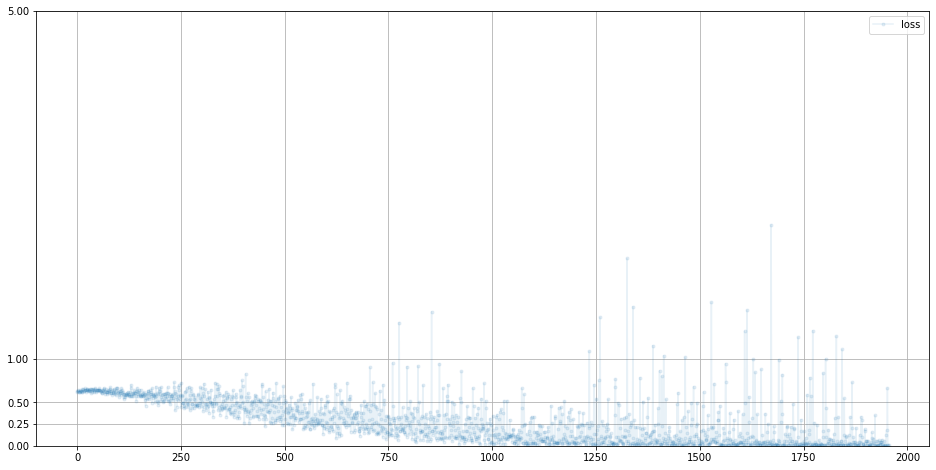

In [12]:
D.plot_progress()

In [13]:
class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(G_input,200),
            nn.Sigmoid(),
            nn.Linear(200,max_length_smiles),
            nn.Sigmoid()
        )
        
        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        
        pass
    
    
    def forward(self, inputs):        
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass
    
    pass

In [14]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(G_input))

print("output", output)


output tensor([[0.3915, 0.4238, 0.4575, 0.6181, 0.6495, 0.4768, 0.4591, 0.5179, 0.5590,
         0.3151, 0.4848, 0.3449, 0.4894, 0.6304, 0.5287, 0.3846, 0.5369, 0.5809,
         0.5608, 0.4318, 0.4478, 0.4797, 0.4639, 0.4482, 0.6312, 0.6416, 0.3653,
         0.4741, 0.4928]], grad_fn=<SigmoidBackward>)


In [ ]:
%%time 
D = Discriminator()
D.to(device)

G = Generator()
G.to(device)


epochs = 50

for epoch in range(epochs):
    print ("epoch = ", epoch + 1)

    # train Discriminator and Generator
    for smiles,label,target in data_loader:
        # train discriminator on true
        D.train(smiles, torch.cuda.FloatTensor([1.0]))

        # train discriminator on false
        # use detach() so gradients in G are not calculated
        D.train(G.forward(generate_random_seed(G_input)).detach(), torch.cuda.FloatTensor([0.0]))
        # train generator
        G.train(D, generate_random_seed(G_input), torch.cuda.FloatTensor([1.0]))

    pass
    
pass

epoch =  1
counter =  10000
counter =  20000
counter =  30000
counter =  40000
counter =  50000
counter =  60000
counter =  70000
counter =  80000
counter =  90000
counter =  100000
counter =  110000
counter =  120000
counter =  130000
counter =  140000
counter =  150000
counter =  160000
counter =  170000
counter =  180000
counter =  190000
counter =  200000
counter =  210000
counter =  220000
counter =  230000
counter =  240000
counter =  250000
counter =  260000
epoch =  2
counter =  270000
counter =  280000
counter =  290000
counter =  300000
counter =  310000
counter =  320000
counter =  330000
counter =  340000
counter =  350000
counter =  360000
counter =  370000
counter =  380000
counter =  390000
counter =  400000
counter =  410000
counter =  420000
counter =  430000
counter =  440000
counter =  450000
counter =  460000
counter =  470000
counter =  480000
counter =  490000
counter =  500000
counter =  510000
counter =  520000
counter =  530000
epoch =  3
counter =  540000
coun

epoch =  17
counter =  4290000
counter =  4300000
counter =  4310000
counter =  4320000
counter =  4330000
counter =  4340000
counter =  4350000
counter =  4360000
counter =  4370000
counter =  4380000
counter =  4390000
counter =  4400000
counter =  4410000
counter =  4420000
counter =  4430000
counter =  4440000
counter =  4450000
counter =  4460000
counter =  4470000
counter =  4480000
counter =  4490000
counter =  4500000
counter =  4510000
counter =  4520000
counter =  4530000
counter =  4540000
counter =  4550000
epoch =  18
counter =  4560000
counter =  4570000
counter =  4580000
counter =  4590000
counter =  4600000
counter =  4610000
counter =  4620000
counter =  4630000
counter =  4640000
counter =  4650000
counter =  4660000
counter =  4670000
counter =  4680000
counter =  4690000
counter =  4700000
counter =  4710000
counter =  4720000
counter =  4730000
counter =  4740000
counter =  4750000
counter =  4760000
counter =  4770000
counter =  4780000
counter =  4790000
counter

In [17]:
import pickle
from datetime import datetime

now = datetime.now() 
date_time = now.strftime("%Y_%m_%d_%H_%M")
G_filename = 'pre_train_model/GAN6_G_' + date_time + '.sav'
print('save model to file:', G_filename)
pickle.dump(G, open(G_filename, 'wb'))

D_filename = 'pre_train_model/GAN6_D_' + date_time + '.sav'
print('save model to file:', D_filename)
pickle.dump(D, open(D_filename, 'wb'))

G_model = pickle.load(open(G_filename, 'rb'))
D_model = pickle.load(open(D_filename, 'rb'))

output = G_model.forward(generate_random_seed(max_length_smiles))
D_model.forward(output)

save model to file: pre_train_model/GAN5_G_2021_04_08_21_48.sav
save model to file: pre_train_model/GAN5_D_2021_04_08_21_48.sav


tensor([0.5000], grad_fn=<SigmoidBackward>)

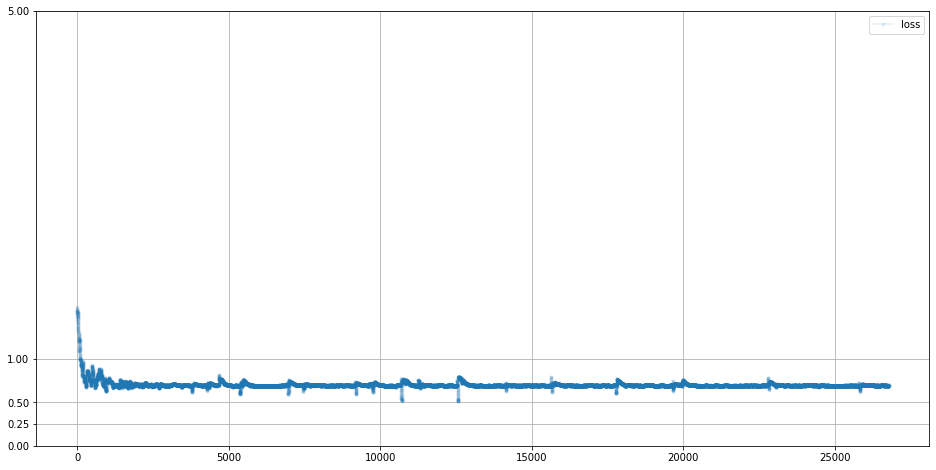

In [18]:
D.plot_progress()

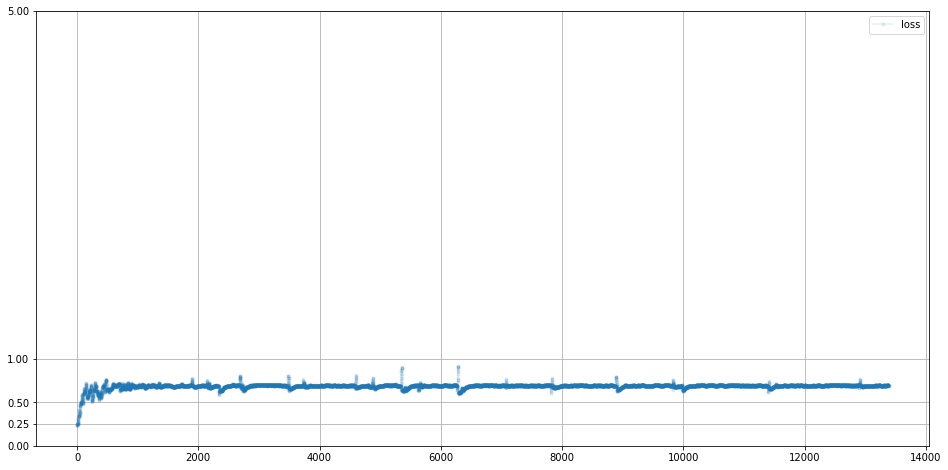

In [19]:
G.plot_progress()

In [21]:
for i in range(10):
    output = G.forward(generate_random_seed(max_length_smiles))
    smiles = output.detach().cpu().numpy() * 128
    print("smiles:", smiles.astype(int) )           
    #print(convertASCIIToString(smiles))
    pass

for i in range(10):
    data_tensor,_,_ = qm9dataset[random.randint(0,130000)]
    #print(D_model.forward(data_tensor).item())
    print(D.forward( data_tensor ).item() )

smiles: [[ 96  46 124  58  85  11 123  72  75 117  56  29  81  55  90  93  64  34
   56   4  46  10  44  27  48  45  30  75   5]]
smiles: [[ 97  46 125  54  87  11 124  74  76 117  52  29  83  52  91  93  63  33
   56   4  49  10  45  29  49  48  29  70   5]]
smiles: [[ 97  45 124  60  87  11 124  77  75 118  54  27  85  54  90  94  63  33
   54   4  46  10  45  27  49  47  31  73   5]]
smiles: [[ 97  45 124  59  86  11 124  73  75 118  52  28  82  53  91  95  63  33
   55   4  47  10  44  28  50  47  30  73   5]]
smiles: [[ 97  45 125  58  86  10 124  76  73 118  54  24  83  55  91  95  63  33
   55   4  46  10  46  27  49  47  30  74   5]]
smiles: [[ 97  46 125  57  86  12 124  70  73 118  54  26  80  54  92  92  64  32
   57   4  48  10  46  27  48  48  29  75   5]]
smiles: [[ 97  46 125  56  85  11 124  71  76 117  52  27  84  50  90  93  65  33
   55   4  46  10  44  27  49  46  30  73   5]]
smiles: [[ 96  45 125  57  84  10 124  71  74 118  51  27  82  56  92  93  62  32
   55   